# Import section

In [37]:
from sys import exit

import multiprocessing
from multiprocessing import Manager

from astropy.io import ascii as asci
from astropy.io.votable import is_votable, parse
from astropy.table import Table, vstack
from astropy.coordinates import SkyCoord
from astropy import units as u
import numpy as np
            
import matplotlib.pyplot as plt
from matplotlib.colors import from_levels_and_colors
from matplotlib.markers import MarkerStyle
import matplotlib.lines as mlines

from cosmolopy.distance import comoving_distance_transverse
cosmo = {'omega_M_0' : 0.3, 'omega_lambda_0' : 0.7, 'omega_k_0' : 0.0, 'h' : 0.72}

from stage2 import *

# DATA TREATMENT SECTION

## Checking that file format is correct

In [2]:
pathdata = "outputs/"
data     = ["matching_fieldGals_Cassata_and_Zurich_corrected_radius_v2.vot"]

for name in data:
    voTag = is_VOtable(pathdata+name)
    if voTag:        
        fullFileName = pathdata + name
        #Retrieving the data
        table = parse(fullFileName)
        full  = table.get_first_table()
        
        print("Size of", name, "is", full.array.shape[0], "\n")
    else:
        exit("Exiting")

The file outputs/matching_fieldGals_Cassata_and_Zurich_corrected_radius_v2.vot is a VOtable, right ? True
Size of matching_fieldGals_Cassata_and_Zurich_corrected_radius_v2.vot is 261 



## Getting data

In [3]:
catalog = parse(pathdata+data[0]).get_first_table().array
fields  = np.asarray(catalog.dtype.names)

#Checking that the matching procedure did not duplicate galaxies
checkDupplicates([catalog], names=["matching_fieldGals_Cassata_and_Zurich_corrected_radius.vot"])

#Converting to an astropy table for simplicity
table = Table(catalog)      

printSimpleStat([catalog['Separation_ZURICH']], unit=u.arcsec)
print("\nNumber of galaxies in matching catalog:", np.shape(table)[0])

All the galaxies are only listed once in the catalog matching_fieldGals_Cassata_and_Zurich_corrected_radius.vot
Stat for catalog number 0 :
Maximum separation is 0.66913126003908 arcsec.
Mean separation is -3256.312416442096 arcsec.
Median separation is 0.04296047126367109 arcsec.
1st quantile is -9999.0.
3rd quantile is 0.09477883642092895.

Number of galaxies in matching catalog: 261


## Correlation between Flux(OII) and SNR

### Getting OII flux and flux error to compute SNR

In [12]:
redshift = table['Z_MUSE']
fluxOII = table['OII_3726_FLUX'] + table['OII_3729_FLUX']
errflux = table['OII_3726_FLUX_ERR'] + table['OII_3729_FLUX_ERR']

### Checking and removing nan values in tables

In [13]:
m = maskToRemoveVal([fluxOII, errflux], astroTableMask=True)
m = np.logical_and(m, maskToRemoveVal([fluxOII, errflux]))

fluxOII, errflux, redshift = applyMask([fluxOII, errflux, redshift], m)

findWhereIsValue([fluxOII, errflux])

No nan was found in array number 0
No nan was found in array number 1


[False, False]

### Computing SNR

In [14]:
SNR     = fluxOII/errflux

### Plotting Flux(OII) vs SNR

(<matplotlib.axes._subplots.AxesSubplot at 0x7f4cb4efbcf8>,
 <matplotlib.collections.PathCollection at 0x7f4cb4ee4e10>)

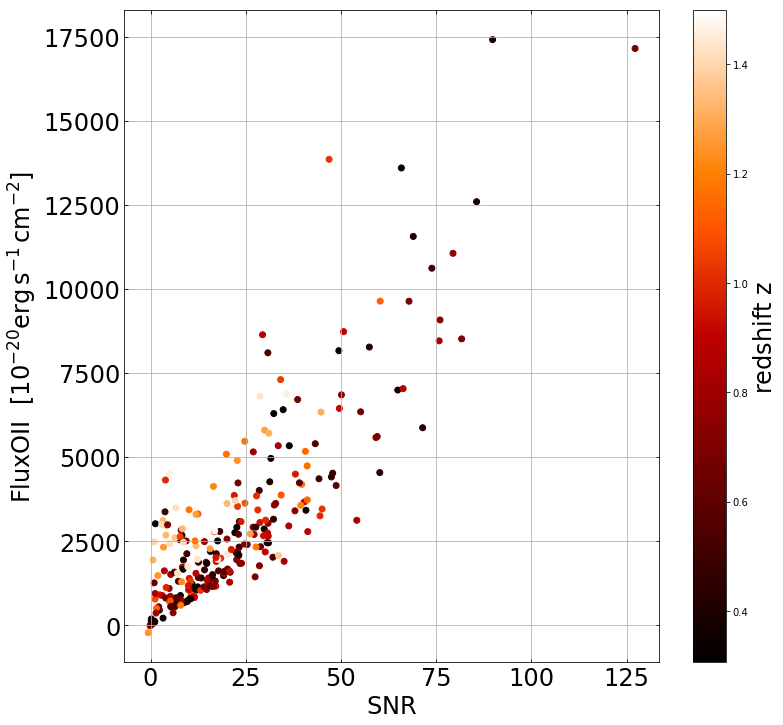

In [16]:
plt.rcParams["figure.figsize"] = (12, 12) # (w, h)
f = plt.figure()
plt.subplots_adjust(wspace=0.45, hspace=0.05)

asManyPlots(111, SNR, fluxOII, xlabel=r'$\rm{SNR}$', ylabel=r'$\rm{Flux OII \ \ [10^{-20} erg \, s^{-1} \, cm^{-2}]}$',
            plotFlag=False, color=[redshift], marker='o', cmap='gist_heat', 
            showColorbar=True, colorbarLabel=r'$\rm{redshift \,\, z}$',
            outputName='Plots/Selection_plots/Flux_vs_SNR.pdf', overwrite=True)

## Plotting size against mass

### Getting data

In [12]:
#Converting size in arcsec
size                  = table['Corrected_radius']*0.03
redshift              = table['Z_MUSE']
lmass                 = table['lmass']

#Useful to compute SNR to make a cut
fluxOII = table['OII_3726_FLUX'] + table['OII_3729_FLUX']
errflux = table['OII_3726_FLUX_ERR'] + table['OII_3729_FLUX_ERR']

#Compute and apply mask
m       = np.logical_and(maskToRemoveVal([fluxOII, errflux, size, lmass], astroTableMask=True),
                         maskToRemoveVal([fluxOII, errflux, size, lmass]))

lmass, size, fluxOII, errflux, redshift = applyMask([lmass, size, fluxOII, errflux, redshift], m)
findWhereIsValue([fluxOII, errflux, size, lmass])

#Compute SNR
SNR     = fluxOII/errflux

No nan was found in array number 0
No nan was found in array number 1
No nan was found in array number 2
No nan was found in array number 3


### Splitting into gals we want and gals we do not want

In [13]:
seeing          = 0.35 #arcsec
m1              = np.where(np.logical_or(size<seeing, SNR<10))
m2              = np.where(np.logical_and(size>=seeing, SNR>=10))

sizeNotWant, lmassNotWant, zNotWant      = applyMask([size, lmass, redshift], m1)
sizeGalsWeWant, lmassGalsWeWant, zWeWant = applyMask([size, lmass, redshift], m2)

### Converting size from arcsec to kpc

In [14]:
#Transforming from arcsec to radians
sizeGalsWeWant /= 3600 #arcsec to degrees
sizeNotWant    /= 3600
sizeGalsWeWant *= np.pi/180.0 #degrees to radians
sizeNotWant    *= np.pi/180.0

#Transforming angular size in comsological transverse size
sizeGalsWeWant *= comoving_distance_transverse(zWeWant, **cosmo)
sizeGalsWeWant *= 1.0e3 #Mpc to kpc
sizeNotWant    *= comoving_distance_transverse(zNotWant, **cosmo)
sizeNotWant    *= 1.0e3

### Plotting

(<matplotlib.axes._subplots.AxesSubplot at 0x7f67b9484fd0>,
 <matplotlib.collections.PathCollection at 0x7f67b87dde10>)

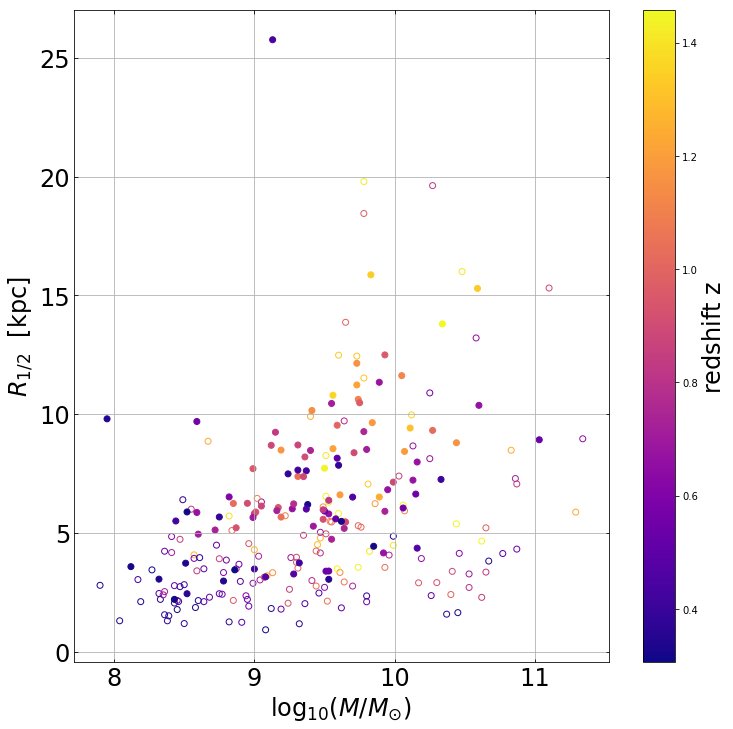

In [19]:
plt.rcParams["figure.figsize"] = (12, 12) # (w, h)
f = plt.figure()
plt.subplots_adjust(wspace=0.45, hspace=0.05)

asManyPlots(111, [lmassGalsWeWant, lmassNotWant], 
                 [sizeGalsWeWant, sizeNotWant], 
            xlabel=r'$\log_{10} (M/M_{\odot})$', ylabel=r'$R_{1/2} \ \ [\rm{kpc}]$',
            plotFlag=[False, False], 
            color=[zWeWant, zNotWant], 
            zorder=[1, 0],
            marker=['o', 'o'],
            unfilledFlag=[False, True],
            cmap='plasma', 
            showColorbar=True, 
            colorbarLabel=r'$\rm{redshift \,\, z}$',
            outputName='Plots/Selection_plots/size_vs_log10Mass.pdf', overwrite=False)

## SNR vs size (arcsec)

### Getting data and Computing SNR

In [4]:
redshift = table['Z_MUSE']

#Converting size in arcsec
size    = table['Corrected_radius']*0.03

fluxOII = table['OII_3726_FLUX'] + table['OII_3729_FLUX']
errflux = table['OII_3726_FLUX_ERR'] + table['OII_3729_FLUX_ERR']

m       = np.logical_and(maskToRemoveVal([fluxOII, errflux, size], astroTableMask=True),
                         maskToRemoveVal([fluxOII, errflux, size]))

size, fluxOII, errflux, redshift = applyMask([size, fluxOII, errflux, redshift], m)

findWhereIsValue([fluxOII, errflux, size])

SNR     = fluxOII/errflux

No nan was found in array number 0
No nan was found in array number 1
No nan was found in array number 2


### Plotting SNR vs size (in arcsec)

File Plots/Selection_plots/SNR_vs_R_halfLight_arcsec.pdf already exists but overwritting was disabled. Thus exiting without writing.


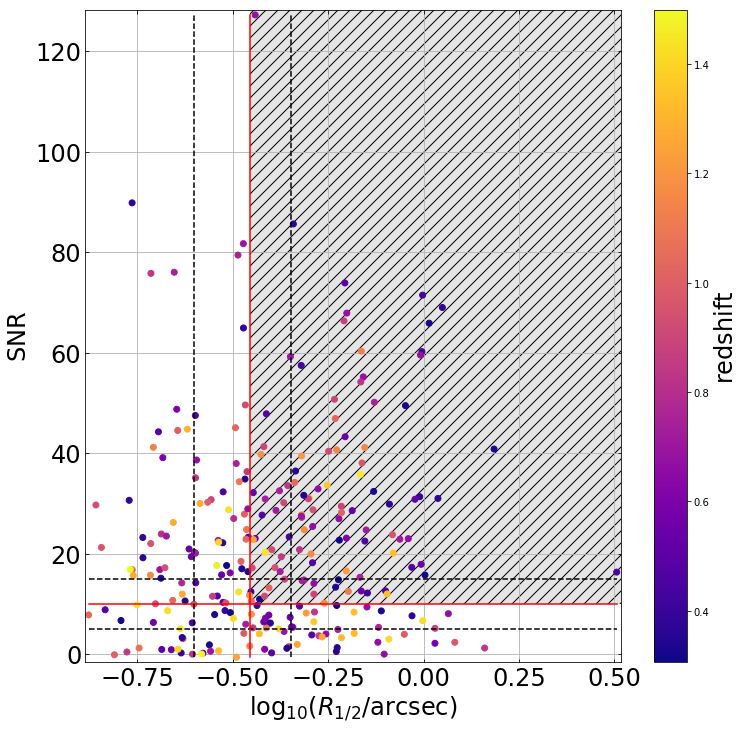

In [12]:
plt.rcParams["figure.figsize"] = (12, 12) # (w, h)
f = plt.figure()
plt.subplots_adjust(wspace=0.45, hspace=0.05)

lsize =  np.log10(size)

SNRLineX     = [np.min(lsize), np.max(lsize)]
SNRLinedownX = [np.min(lsize), np.max(lsize)]
SNRLineupX   = [np.min(lsize), np.max(lsize)]
SNRLineY     = [10, 10]
SNRLinedownY = [5, 5]
SNRLineupY   = [15, 15]

lszLineX     = [np.log10(0.35), np.log10(0.35)]
lszLinedownX = [np.log10(0.25), np.log10(0.25)]
lszLineupX   = [np.log10(0.45), np.log10(0.45)]
lszLineY     = [np.min(SNR), np.max(SNR)]
lszLinedownY = [np.min(SNR), np.max(SNR)]
lszLineupY   = [np.min(SNR), np.max(SNR)]

ax, tmp = asManyPlots(111, [lsize, SNRLineX, SNRLinedownX, SNRLineupX, lszLineX, lszLinedownX, lszLineupX], 
            [SNR, SNRLineY, SNRLinedownY, SNRLineupY, lszLineY, lszLinedownY, lszLineupY], 
            ylabel=r'$\rm{SNR}$', xlabel=r'$\log_{10} (R_{1/2} / \rm{arcsec})$',
            plotFlag=[False, True, True, True, True, True, True], 
            color=[redshift, 'r', 'k', 'k', 'r', 'k', 'k'], 
            zorder=[2, 3, 4, 5, 6, 7, 8],
            marker=['o', 'None', 'None', 'None', 'None', 'None', 'None'], 
            linestyle=['None', 'solid', 'dashed', 'dashed', 'solid', 'dashed', 'dashed'],
            cmap='plasma', showColorbar=True, colorbarLabel=r'$\rm{redshift}$',
            outputName='Plots/Selection_plots/SNR_vs_R_halfLight_arcsec.pdf', overwrite=False,
            xlim=[np.min(lsize)-0.01, np.max(lsize)+0.01],
            ylim=[np.min(SNR)-1, np.max(SNR)+1])

ax.fill_between([np.log10(0.35), np.max(lsize)+0.1], [10, 10], [np.max(SNR)+20, np.max(SNR)+20], zorder=0, alpha=0,
                 hatch='//')
ax.fill_between([np.log10(0.35), np.max(lsize)+0.1], [10, 10], [np.max(SNR)+20, np.max(SNR)+20], zorder=1, facecolor='k', alpha=0.1)

plt.savefig('Plots/Selection_plots/SNR_vs_R_halfLight_arcsec.pdf', overwrite=False, bbox_inches='tight')

## SNR vs comoving transverse distance

### Getting data and Computing SNR

In [29]:
redshift = table['Z_MUSE']

#Converting size in arcsec
size    = table['Corrected_radius']*0.03

fluxOII = table['OII_3726_FLUX'] + table['OII_3729_FLUX']
errflux = table['OII_3726_FLUX_ERR'] + table['OII_3729_FLUX_ERR']

m       = np.logical_and(maskToRemoveVal([fluxOII, errflux, size], astroTableMask=True),
                         maskToRemoveVal([fluxOII, errflux, size]))

size, fluxOII, errflux, redshift = applyMask([size, fluxOII, errflux, redshift], m)

findWhereIsValue([fluxOII, errflux, size])

SNR     = fluxOII/errflux

#Transforming from arcsec to radians
size /= 3600 #arcsec to degrees
size *= np.pi/180.0 #degrees to radians

#Transforming angular size in comsological transverse size
size *= comoving_distance_transverse(redshift, **cosmo)
size *= 1.0e3 #Mpc to kpc

No nan was found in array number 0
No nan was found in array number 1
No nan was found in array number 2


### Plotting SNR vs comoving transverse distance

(<matplotlib.axes._subplots.AxesSubplot at 0x7f4cb1439320>,
 [<matplotlib.lines.Line2D at 0x7f4cb14e7470>])

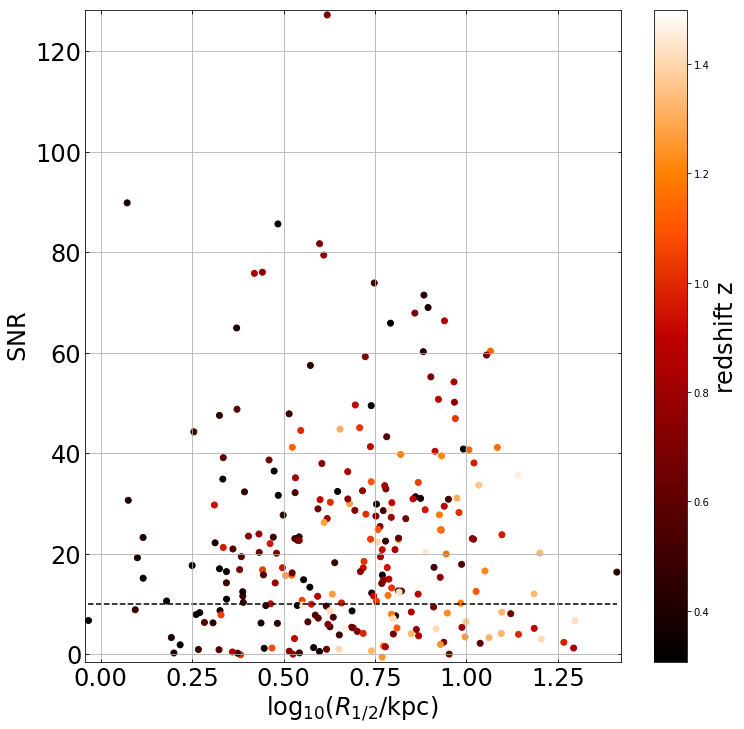

In [32]:
plt.rcParams["figure.figsize"] = (12, 12) # (w, h)
f = plt.figure()
plt.subplots_adjust(wspace=0.45, hspace=0.05)

lsize =  np.log10(size)

SNRLineX = [np.min(lsize), np.max(lsize)]
SNRLineY = [10, 10]

asManyPlots(111, [lsize, SNRLineX], [SNR, SNRLineY], 
            ylabel=r'$\rm{SNR}$', xlabel=r'$\log_{10}(R_{1/2} / \rm{kpc})$',
            plotFlag=[False, True], color=[redshift, 'k'], zorder=[0,1],
            marker=['o', 'None', 'None'], linestyle=['None', 'dashed', 'dashed'],
            cmap='gist_heat', showColorbar=True, colorbarLabel=r'$\rm{redshift \,\, z}$',
            outputName='Plots/Selection_plots/SNR_vs_R_halfLight_kpc.pdf', overwrite=False,
            xlim=[np.min(lsize)-0.01, np.max(lsize)+0.01],
            ylim=[np.min(SNR)-1, np.max(SNR)+1])

## Redshift histograms

### Getting data and Computing SNR

In [4]:
redshift = table['Z_MUSE']

#Converting size in arcsec
size    = table['Corrected_radius']*0.03

fluxOII = table['OII_3726_FLUX'] + table['OII_3729_FLUX']
errflux = table['OII_3726_FLUX_ERR'] + table['OII_3729_FLUX_ERR']

m       = np.logical_and(maskToRemoveVal([fluxOII, errflux, size], astroTableMask=True),
                         maskToRemoveVal([fluxOII, errflux, size]))

size, fluxOII, errflux, redshift = applyMask([size, fluxOII, errflux, redshift], m)

findWhereIsValue([fluxOII, errflux, size])

SNR     = fluxOII/errflux

No nan was found in array number 0
No nan was found in array number 1
No nan was found in array number 2


### Splitting data into gals we want and gals we do not want

In [5]:
zFromGalsWeWant  = redshift[np.logical_and(SNR>10, size>=0.35)]
zFromGalsNotWant = redshift[np.logical_or(SNR<=10, size<0.35)]

meanZ = np.mean(zFromGalsWeWant)

print("Number of gals without cuts", np.shape(redshift)[0])
print("Number of gals", np.shape(zFromGalsWeWant)[0])
print("Mean redshift", np.mean(zFromGalsWeWant))
print("Median redshift", np.median(zFromGalsWeWant))

Number of gals without cuts 258
Number of gals 103
Mean redshift 0.7494067590213517
Median redshift 0.7188599705696106


/home/wilfried/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


### Plotting histograms

0.10847545
0.10847548
0.10847545
0.10847545
0.10847545
0.10847545
0.10847545
0.10847545
0.10847545
0.10847545
0.10847545


/home/wilfried/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


0.7494067590213517 0.7188599705696106 0.8085624448714718 0.7496100068092346


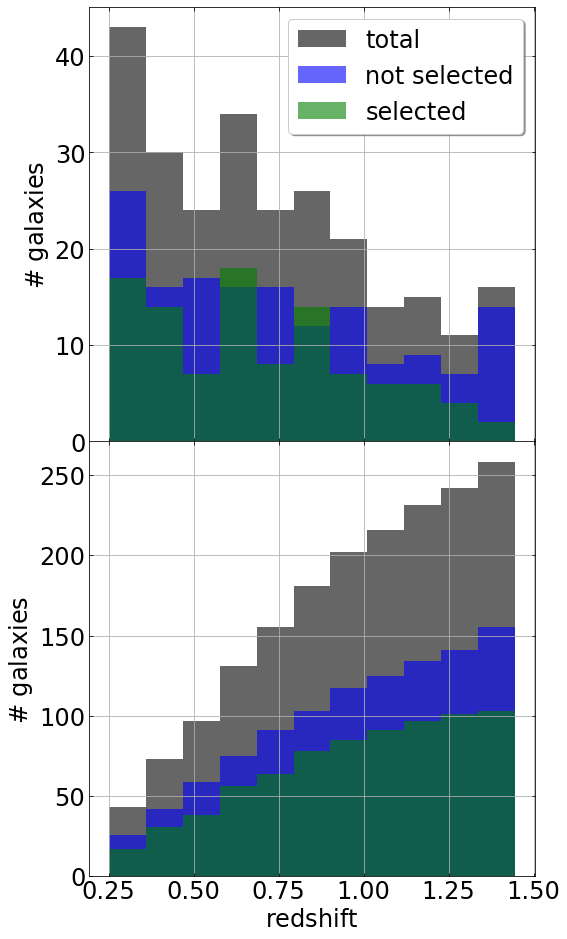

In [18]:
plt.rcParams["figure.figsize"] = (8, 16) # (w, h)
f = plt.figure()
plt.subplots_adjust(wspace=0.05, hspace=0.0)


[zFromGalsNotWant, zFromGalsWeWant]
['black', 'red']
['red', 'black']
label=['not selected', 'selected']

zTot = np.append(zFromGalsNotWant, zFromGalsWeWant)

#Trying to have bins around 0.1 in width
bins = int((np.max(zFromGalsWeWant)-np.min(zFromGalsWeWant))/0.1)
ax, n, bns, ptchs = asManyHists(211, [zFromGalsWeWant, zFromGalsNotWant, zTot], bins=bins,
                        xlabel=r'$\rm{redshift}$', ylabel=r'$\rm{\# \,\, galaxies}$',
                        hideXlabel=True, hideXticks=True,
                        hatch=None,
                        color=['green', 'blue', 'black'], histtype='stepfilled', align='left',
                        label=['selected', 'not selected', 'total'], showLegend=True, alpha=0.6)

#Check bins are correct
for i in range(len(bns)-1):
    print(bns[i+1]-bns[i])

zTot = np.append(zFromGalsNotWant, zFromGalsWeWant)

#Trying to have bins around 0.1 in width
bins = int((np.max(zFromGalsWeWant)-np.min(zFromGalsWeWant))/0.1)
ax, n, bns, ptchs = asManyHists(212, [zFromGalsWeWant, zFromGalsNotWant, zTot], bins=bins,
                        xlabel=r'$\rm{redshift}$', ylabel=r'$\rm{\# \,\, galaxies}$',
                        color=['green', 'blue', 'black'], histtype='stepfilled', align='left',
                        label=['selected', 'not selected', 'total'], showLegend=False, alpha=0.6,
                        cumulative=True,
                        locLegend='upper left')
plt.savefig('Plots/Selection_plots/cumulative_hist_redshift.pdf', bbox_inches='tight')

print(np.mean(zFromGalsWeWant), np.median(zFromGalsWeWant), np.mean(zFromGalsNotWant), np.median(zFromGalsNotWant))

## CosmosID histograms

### Getting data and Computing SNR

In [6]:
cosmoID  = table['COSMOS_Group_Number']

#Converting size in arcsec
size    = table['Corrected_radius']*0.03

fluxOII = table['OII_3726_FLUX'] + table['OII_3729_FLUX']
errflux = table['OII_3726_FLUX_ERR'] + table['OII_3729_FLUX_ERR']

m       = np.logical_and(maskToRemoveVal([fluxOII, errflux, size, cosmoID], astroTableMask=True),
                         maskToRemoveVal([fluxOII, errflux, size, cosmoID]))

cosmoID, size, fluxOII, errflux = applyMask([cosmoID, size, fluxOII, errflux], m)

findWhereIsValue([fluxOII, errflux, size, cosmoID])

SNR     = fluxOII/errflux

No nan was found in array number 0
No nan was found in array number 1
No nan was found in array number 2
No nan was found in array number 3


### Splitting data into gals we want and gals we do not want

In [7]:
IDWant    = cosmoID[np.logical_and(SNR>10, size>=0.35)]
IDNotWant = cosmoID[np.logical_or(SNR<=10, size<0.35)]

### Plotting histogram of COSMOS ID

In [26]:
bins = range(int(np.max([np.max(IDWant), np.max(IDNotWant), np.max(IDTot)])))
print(bins)

range(0, 114)


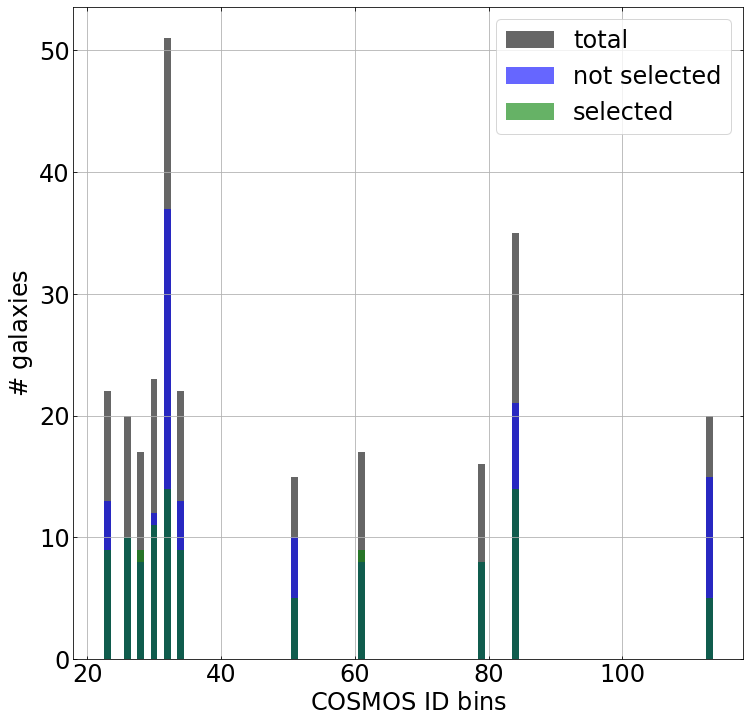

In [34]:
plt.rcParams["figure.figsize"] = (12, 12) # (w, h)
f = plt.figure()
plt.subplots_adjust(wspace=0.45, hspace=0.05)


['black', 'red']
['red', 'black']
label=['not selected', 'selected']

IDTot = np.append(np.asarray(IDWant), np.asarray(IDNotWant))

#Trying to have bins around 0.1 in width
bins = range(int(np.min(IDTot)), int(np.max(IDTot)+1))
ax, n, bns = asManyHists(111, [IDWant, IDNotWant, IDTot], bins=bins,
                        xlabel=r'$\rm{COSMOS \,\, ID \,\, bins}$', ylabel=r'$\rm{\# \,\, galaxies}$',
                        color=['green', 'blue', 'black'], histtype='stepfilled', align='left',
                        label=['selected', 'not selected', 'total'], showLegend=True, alpha=0.6,
                        outputName='Plots/Selection_plots/hist_COSMOSID.pdf', overwrite=False)

## SFR vs mass (with FAST values)

### Getting data and Computing SNR

In [60]:
#Converting size in arcsec
size                  = table['Corrected_radius']*0.03
redshift              = table['Z_MUSE']
lmass                 = table['lmass']
lsfr                  = table['lsfr']

#Useful to compute SNR to make a cut
fluxOII = table['OII_3726_FLUX'] + table['OII_3729_FLUX']
errflux = table['OII_3726_FLUX_ERR'] + table['OII_3729_FLUX_ERR']

#Compute and apply mask
m       = np.logical_and(maskToRemoveVal([fluxOII, errflux, size], astroTableMask=True),
                         maskToRemoveVal([fluxOII, errflux, size]))

lsfr, lmass, size, fluxOII, errflux, redshift = applyMask([lsfr, lmass, size, fluxOII, errflux, redshift], m)
findWhereIsValue([fluxOII, errflux, size, lmass, lsfr])

#Compute SNR
SNR     = fluxOII/errflux

#Apply relevant cut
m       = np.logical_and(SNR>10, size>=0.35)
zFromGalsWeWant, lsfrGalsWeWant, lmassGalsWeWant = applyMask([redshift, lsfr, lmass], m)

#Compute and apply mask
m       = np.logical_and(maskToRemoveVal([lsfrGalsWeWant, lmassGalsWeWant], astroTableMask=True),
                         maskToRemoveVal([lsfrGalsWeWant, lmassGalsWeWant]))

zFromGalsWeWant, lsfrGalsWeWant, lmassGalsWeWant = applyMask([zFromGalsWeWant, lsfrGalsWeWant, lmassGalsWeWant], m)
findWhereIsValue([lsfrGalsWeWant, lmassGalsWeWant])

meanZ = np.mean(zFromGalsWeWant)

print("\nNumber of gals", np.shape(zFromGalsWeWant)[0])
print("Mean redshift", np.mean(zFromGalsWeWant))
print("Median redshift", np.median(zFromGalsWeWant))

No nan was found in array number 0
No nan was found in array number 1
No nan was found in array number 2
No nan was found in array number 3
No nan was found in array number 4
No nan was found in array number 0
No nan was found in array number 1

Number of gals 103
Mean redshift 0.7494067590213517
Median redshift 0.7188599705696106


### Plotting SFR vs mass (with FAST values)

File Plots/Selection_plots/SFR_vs_mass.pdf already exists but overwritting was disabled. Thus exiting without writing.


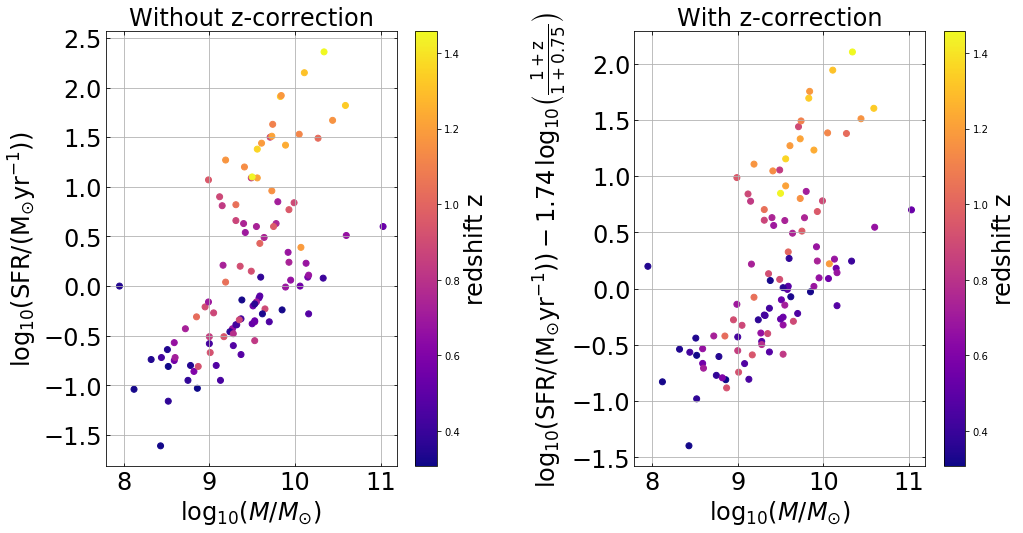

In [61]:
plt.rcParams["figure.figsize"] = (16, 8) # (w, h)
f = plt.figure()
plt.subplots_adjust(wspace=0.45, hspace=0.05)

ax1, tmp = asManyPlots(121, lmassGalsWeWant, lsfrGalsWeWant,
                       ylabel=r'$\log_{10} (\rm{SFR}/(M_{\odot} \rm{yr}^{-1}))$',
                       xlabel=r'$\log_{10} ( M/M_{\odot})$',
                       marker='o', colorbarLabel=r'$\rm{redshift \,\, z}$',
                       showColorbar=True, plotFlag=False,
                       color=[zFromGalsWeWant],
                       cmap='plasma', title='Without z-correction', outputName='Plots/Selection_plots/SFR_vs_mass.pdf', overwrite=False)

correctedSfr = lsfrGalsWeWant - 1.74*np.log10((1+zFromGalsWeWant)/(1+meanZ))

ylabel   = r'$\log_{10} (\rm{SFR}/(M_{\odot} \rm{yr}^{-1})) - 1.74 \, \log_{10} \left ( \frac{1+z}{1+%.2f} \right )$' %meanZ
ax1, tmp = asManyPlots(122, lmassGalsWeWant, correctedSfr,
                       ylabel=ylabel,
                       xlabel=r'$\log_{10} ( M/M_{\odot})$',
                       marker='o', colorbarLabel=r'$\rm{redshift \,\, z}$',
                       showColorbar=True, plotFlag=False,
                       color=[zFromGalsWeWant],
                       cmap='plasma', title='With z-correction', outputName='Plots/Selection_plots/SFR_vs_mass.pdf', overwrite=False)

## SFR vs mass (with morphological values)

### Getting data and Computing SNR

In [20]:
#Converting size in arcsec
size                  = table['Corrected_radius']*0.03
redshift              = table['Z_MUSE']
massMed               = table['MASS_MED']
massBest              = table['MASS_BEST']
sfrMED                = table['SFR_MED']
sfrBEST               = table['SFR_BEST']

#Useful to compute SNR to make a cut
fluxOII = table['OII_3726_FLUX'] + table['OII_3729_FLUX']
errflux = table['OII_3726_FLUX_ERR'] + table['OII_3729_FLUX_ERR']

#Compute and apply mask
m       = np.logical_and(maskToRemoveVal([fluxOII, errflux, size], astroTableMask=True),
                         maskToRemoveVal([fluxOII, errflux, size]))

massMed, massBest, sfrMED, sfrBEST, size, fluxOII, errflux, redshift = applyMask([massMed, massBest, sfrMED, sfrBEST, 
                                                                                  size, fluxOII, errflux, redshift], m)
findWhereIsValue([fluxOII, errflux, size])

#Compute SNR
SNR     = fluxOII/errflux

No nan was found in array number 0
No nan was found in array number 1
No nan was found in array number 2


### Checking median and best values for SFR and mass are similar

File Plots/Selection_plots/comparingMorphoSFRsAndMasses.pdf already exists but overwritting was disabled. Thus exiting without writing.


(<matplotlib.axes._subplots.AxesSubplot at 0x7f928495abe0>,
 [<matplotlib.lines.Line2D at 0x7f9284b71240>])

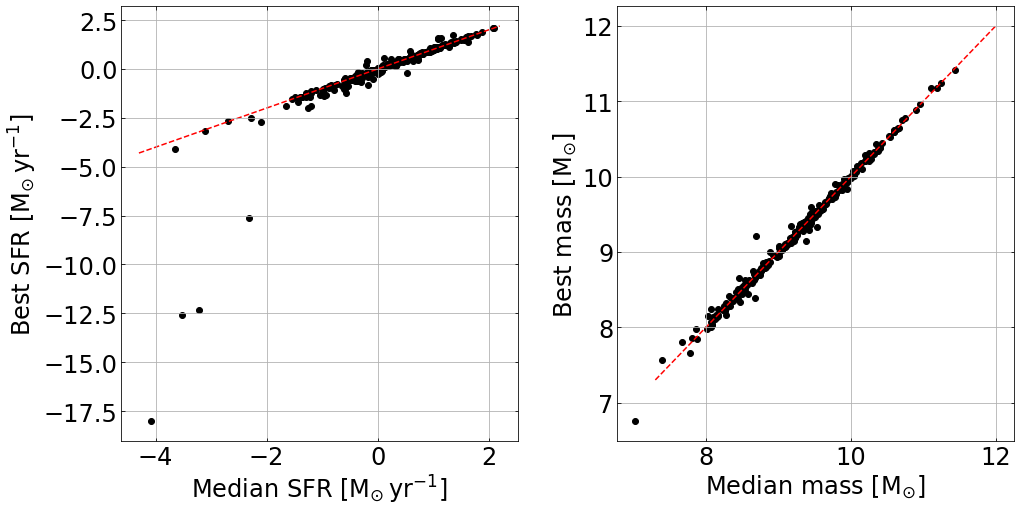

In [21]:
plt.rcParams["figure.figsize"] = (16, 8) # (w, h)
f = plt.figure()
plt.subplots_adjust(wspace=0.25, hspace=0.05)

xLine = [-4.3, 2.2]
yLine = xLine
asManyPlots(121, [sfrMED, xLine], [sfrBEST, yLine], 
            xlabel=r'$\rm{Median \,\, SFR \,\, [M_{\odot} \, yr^{-1}]}$', ylabel=r'$\rm{Best \,\, SFR \,\, [M_{\odot} \, yr^{-1}]}$',
            marker=['o', 'None'], linestyle=['None', '--'], color=['k', 'r'],
            unfilledFlag=False)

xLine = [7.3, 12]
yLine = xLine
asManyPlots(122, [massMed, xLine], [massBest, yLine], 
            xlabel=r'$\rm{Median \,\, mass \,\, [M_{\odot}]}$', ylabel=r'$\rm{Best \,\, mass \,\, [M_{\odot}]}$',
            marker=['o', 'None'], linestyle=['None', '--'], color=['k', 'r'],
            outputName='Plots/Selection_plots/comparingMorphoSFRsAndMasses.pdf', overwrite=False)

### Seperate gals we want

In [22]:
#Apply relevant cut
m       = np.logical_and(SNR>10, size>=0.35)
sizeWeWant, zFromGalsWeWant, sfrMedWeWant, massMedWeWant = applyMask([size, redshift, sfrMED, massMed], m)

#Remove potential nan values
m       = np.logical_and(maskToRemoveVal([sfrMedWeWant, massMedWeWant], astroTableMask=True),
                         maskToRemoveVal([sfrMedWeWant, massMedWeWant]))

sizeWeWant, zFromGalsWeWant, sfrMedWeWant, massMedWeWant = applyMask([sizeWeWant, zFromGalsWeWant, sfrMedWeWant, massMedWeWant], m)
findWhereIsValue([sfrMedWeWant, massMedWeWant])

meanZ = np.mean(zFromGalsWeWant)

print("\nNumber of gals", np.shape(zFromGalsWeWant)[0])
print("Mean redshift", np.mean(zFromGalsWeWant))
print("Median redshift", np.median(zFromGalsWeWant))

No nan was found in array number 0
No nan was found in array number 1

Number of gals 103
Mean redshift 0.7494067590213517
Median redshift 0.7188599705696106


/home/wilfried/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


### Seperate gals we do not want

In [23]:
#Apply relevant cut
m       = np.logical_or(SNR<=10, size<0.35)
zNotWant, sizeNotWant, sfrMedNotWant, massMedNotWant = applyMask([redshift, size, sfrMED, massMed], m)

#Remove potential nan values
m       = np.logical_and(maskToRemoveVal([sfrMedNotWant, massMedNotWant], astroTableMask=True),
                         maskToRemoveVal([sfrMedNotWant, massMedNotWant]))

zNotWant, sizeNotWant, sfrMedNotWant, massMedNotWant = applyMask([zNotWant, sizeNotWant, sfrMedNotWant, massMedNotWant], m)
findWhereIsValue([sfrMedNotWant, massMedNotWant])

meanZNotWant = np.mean(zNotWant)

print("\nNumber of gals", np.shape(zNotWant)[0])
print("Mean redshift", np.mean(zNotWant))
print("Median redshift", np.median(zNotWant))

No nan was found in array number 0
No nan was found in array number 1

Number of gals 152
Mean redshift 0.8019435280247739
Median redshift 0.7484650015830994


### Plotting SFR vs mass (with morphological values)

File Plots/Selection_plots/SFR_vs_mass.pdf already exists but overwritting was disabled. Thus exiting without writing.
103


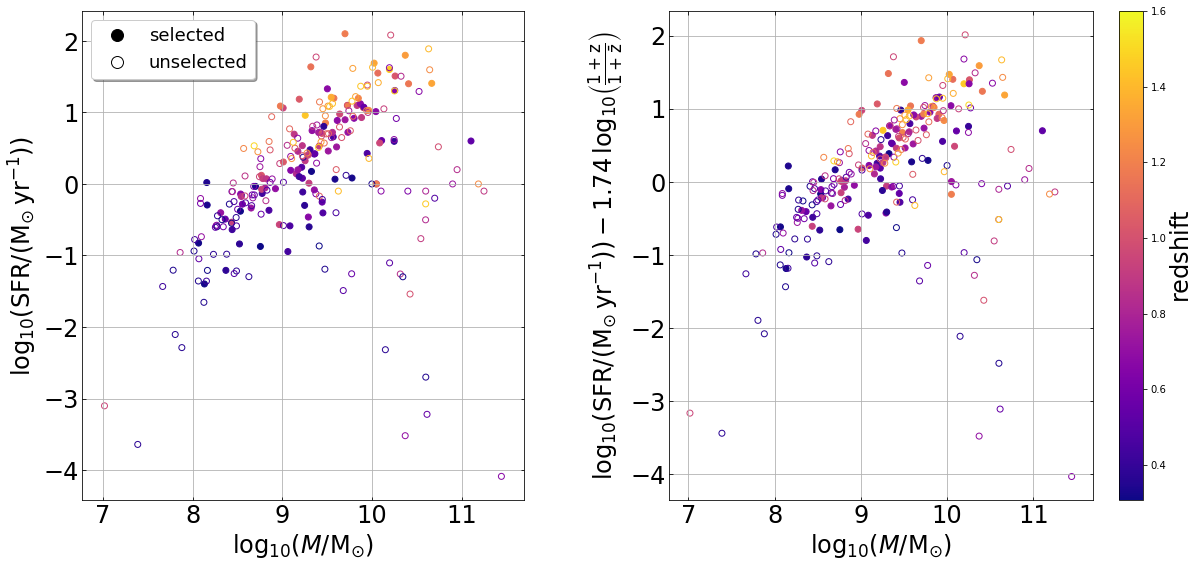

In [64]:
import matplotlib.gridspec as gridspec

plt.rcParams["figure.figsize"] = (20, 9) # (w, h)
f = plt.figure()
plt.subplots_adjust(wspace=0.3, hspace=0.05)

gs = gridspec.GridSpec(1, 2,width_ratios=[1,1.2])

ax1, tmp = asManyPlots(gs[0], [massMedWeWant, massMedNotWant], [sfrMedWeWant, sfrMedNotWant],
                       ylabel=r'$\log_{10} (\rm{SFR}/(\rm{M_{\odot} \, yr}^{-1}))$',
                       xlabel=r'$\log_{10} ( M/\rm{M_{\odot}})$',
                       marker=['o', 'o'],
                       unfilledFlag=[False, True],
                       showColorbar=False, plotFlag=[False, False],
                       color=[zFromGalsWeWant, zNotWant],
                       cmapMax=1.6,
                       cmap='plasma', outputName='Plots/Selection_plots/SFR_vs_mass.pdf', overwrite=False)

selected   = mlines.Line2D([], [], color='black', marker='o', markersize=12, label='selected', linestyle='None')
unselected = mlines.Line2D([], [], color='black', marker='o', markersize=12, fillstyle='none', label='unselected', linestyle='None')
plt.legend(handles=[selected, unselected], loc='upper left', prop={'size': 18}, shadow=True, fancybox=True)

correctedSfr   = sfrMedWeWant - 1.74*np.log10((1+zFromGalsWeWant)/(1+meanZ))
corrSfrNotWant = sfrMedNotWant - 1.74*np.log10((1+zNotWant)/(1+meanZNotWant))
print(len(correctedSfr))

ylabel   = r'$\log_{10} (\rm{SFR}/(M_{\odot} \, \rm{yr}^{-1})) - 1.74 \, \log_{10} \left ( \frac{1+z}{1+\bar{z}} \right )$'
ax1, tmp = asManyPlots(gs[1], [massMedWeWant, massMedNotWant], [correctedSfr, corrSfrNotWant],
                       ylabel=ylabel,
                       xlabel=r'$\log_{10} ( M/\rm{M_{\odot}})$',
                       marker=['o', 'o'], 
                       unfilledFlag=[False, True],
                       colorbarLabel=r'$\rm{redshift}$',
                       showColorbar=True, 
                       plotFlag=[False, False],
                       cmapMax=1.6,
                       color=[zFromGalsWeWant, zNotWant],
                       cmap='plasma', outputName='Plots/Selection_plots/SFR_vs_mass_withoutFAST.pdf', overwrite=True)

### Plotting SFR vs mass (with morphological values, checking size)

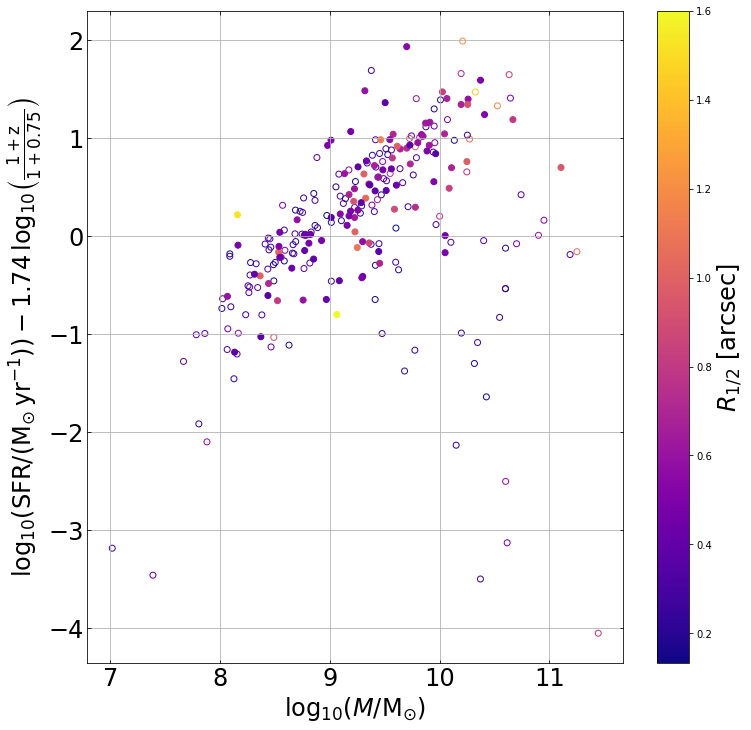

In [14]:
plt.rcParams["figure.figsize"] = (12, 12) # (w, h)
f = plt.figure()
plt.subplots_adjust(wspace=0.45, hspace=0.05)

correctedSfr   = sfrMedWeWant - 1.74*np.log10((1+zFromGalsWeWant)/(1+meanZ))
corrSfrNotWant = sfrMedNotWant - 1.74*np.log10((1+zNotWant)/(1+meanZ))

ylabel   = r'$\log_{10} (\rm{SFR}/(M_{\odot} \, \rm{yr}^{-1})) - 1.74 \, \log_{10} \left ( \frac{1+z}{1+%.2f} \right )$' %meanZ
ax1, tmp = asManyPlots(111, [massMedNotWant, massMedWeWant], [corrSfrNotWant, correctedSfr],
                       ylabel=ylabel,
                       xlabel=r'$\log_{10} ( M/\rm{M_{\odot}})$',
                       marker=['o', 'o'],
                       zorder=[0, 1],
                       unfilledFlag=[True, False],
                       colorbarLabel=r'$R_{1/2} \,\, [\rm{arcsec}]$',
                       showColorbar=True, plotFlag=[False, False],
                       cmapMax=1.6,
                       color=[sizeNotWant, sizeWeWant],
                       cmap='plasma', outputName='Plots/Selection_plots/SFR_vs_mass_withoutFAST_sizeCoding.pdf', overwrite=False)

In [57]:
'Selecting galaxies around boths cuts'.upper()

'SELECTING GALAXIES AROUND BOTHS CUTS'

# SELECTING GALAXIES AROUND BOTHS CUTS

## Selecting galaxies with SNR>10 and size>0.35arcsec

### Getting the list of galaxy IDs and COSMOS Group Number from the list_gal file in scripts_python_Benoit

In [25]:
path  = 'scripts_python_Benoit/'
file  = 'list_gal'
tbl   = asci.read(path+file, guess=False, format='no_header', fast_reader=True)

names = tbl['col1']
zFile = np.asarray(tbl['col2'])

tblGrNumbers = np.copy(names)
tblMUSEID    = np.copy(names)
for i, name in enumerate(names):
    
    #Getting group number of MUSE galaxies
    tblGrNumbers[i] = name.split('/')[2].split('_')[0].split('CGr')[1]
    if tblGrNumbers[i] in ['32-M1', '32-M2', '32-M3']:
        tblGrNumbers[i] = '32'
    if  tblGrNumbers[i] in ['84-N']:
        tblGrNumbers[i] = '84.1'
        
    #Getting MUSE galaxy IDs
    tblMUSEID[i] = name.split('/')[-1].split('_')[-2]
    
tblGrNumbers = np.asarray(tblGrNumbers, dtype='float')
tblMUSEID    = np.asarray(tblMUSEID, dtype='int')

### Getting data of galaxies & Computing SNR and applying mask

In [26]:
GroupNumber = np.asarray(table['COSMOS_Group_Number'], dtype='float')
ID_MUSE     = np.asarray(table['ID'], dtype='int')
zReduced    = np.asarray(table['Z_MUSE'], dtype='float')
rReduced    = np.asarray(table['Corrected_radius'], dtype='float')

redshift = table['Z_MUSE']

#Converting size in arcsec
size    = table['Corrected_radius']*0.03

fluxOII = table['OII_3726_FLUX'] + table['OII_3729_FLUX']
errflux = table['OII_3726_FLUX_ERR'] + table['OII_3729_FLUX_ERR']

m       = np.logical_and(maskToRemoveVal([fluxOII, errflux, size], astroTableMask=True),
                         maskToRemoveVal([fluxOII, errflux, size]))

GroupNumber, ID_MUSE, zReduced, rReduced, size, fluxOII, errflux, redshift, selectedTable = applyMask([GroupNumber, ID_MUSE, zReduced, rReduced, 
                                                                                                       size, fluxOII, errflux, redshift, table], m)
findWhereIsValue([fluxOII, errflux, size])

SNR     = fluxOII/errflux

No nan was found in array number 0
No nan was found in array number 1
No nan was found in array number 2


### Selecting galaxies

In [27]:
seeing       = 0.35 #arcsec
m            = np.where(np.logical_and(SNR >=10, size>=seeing))

GroupNumber, ID_MUSE, zReduced, rReduced, SNRReduced, selectedTable  = applyMask([GroupNumber, ID_MUSE, zReduced, rReduced, SNR, selectedTable], m)

print("Difference between radii before and after selection:")
print(np.asarray(size[m]-(rReduced*0.03)))

print(np.size(selectedTable), np.size(rReduced))

Difference between radii before and after selection:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]
103 103


### Write full array with selected galaxies into a .vot table

In [23]:
outputFile = 'outputs/selected_field_gals.vot'

write_array_to_vot(selectedTable, outputFile, isTable=True)

### Get matching between MUSE ID and ID_in_MUSE_Field which is used in the group number 84 folder to name galaxies

In [13]:
matchingFile = 'data/catalogues/CGR84-83_FD+North_zcatalog_withLaigle+16_withFAST_withnewPLATEFIT_totalflux_withnewz_jan19_withFOF_withGALFIT_withGALKIN_jan19.vot'
is_VOtable(matchingFile)

tmpCOSMOSID   = parse(matchingFile).get_first_table().array['COSMOS_Group_Number']
m             = tmpCOSMOSID==84.0
CatalogMUSEID = parse(matchingFile).get_first_table().array['ID'][m]
FolderMUSEID  = parse(matchingFile).get_first_table().array['ID_in_MUSE_Field'][m]

The file data/catalogues/CGR84-83_FD+North_zcatalog_withLaigle+16_withFAST_withnewPLATEFIT_totalflux_withnewz_jan19_withFOF_withGALFIT_withGALKIN_jan19.vot is a VOtable, right ? True


### Checking that the selected galaxies exist and have the relevant redshift. If they do, keep them

In [18]:
def computing_data(i, gr, idm, zR, snr, sz):
    global tblGrNumbers, CatalogMUSEID, tblMUSEID, zFile, indices
    
    #indices in group 84 are different from those in the catalog, thus changing their value so that they can be found
    if gr==84.0:
        idm = FolderMUSEID[np.where(CatalogMUSEID==idm)][0]
    
    m = np.logical_and(tblGrNumbers==gr, tblMUSEID==idm)
    if np.any(m):
        for j in np.where(m)[0]:
            indices.append(j)
        print('Galaxy CGr%5.1f_%3d number %3d was found with redshit difference %+1.5f, size %3.2f px and SNR %2d' %(gr, idm, i, zR-zFile[m][0], sz, snr))
        return
    else:
        print('Galaxy CGr%5.1f_%3d number %2d not found' %(gr, idm, i))
        return

indices = Manager().list([])
for i, gr, idm, zR, snr, sz in zip(range(len(zReduced)), GroupNumber, ID_MUSE, zReduced, SNRReduced, rReduced):
    proc = multiprocessing.Process(name=i, target=computing_data, args=(i, gr, idm, zR, snr, sz, ))
    proc.start()
    proc.join()

print("\n%2d galaxy indices found in folders" %len(indices), indices)

namesWanted = names[indices]
zWanted     = zFile[indices]

Galaxy CGr 84.1_  8 number   0 was found with redshit difference +0.00000, size 32.58 px and SNR 31
Galaxy CGr 84.1_ 20 number   1 was found with redshit difference -0.00000, size 20.00 px and SNR 26
Galaxy CGr 84.1_ 21 number   2 was found with redshit difference -0.00000, size 17.64 px and SNR 32
Galaxy CGr 84.1_ 62 number   3 was found with redshit difference +0.01903, size 16.03 px and SNR 14
Galaxy CGr 84.1_100 number   4 was found with redshit difference +0.03652, size 15.32 px and SNR 34
Galaxy CGr 84.1_108 number   5 was found with redshit difference +0.02289, size 22.90 px and SNR 60
Galaxy CGr 84.0_ 39 number   6 was found with redshit difference +0.00000, size 17.08 px and SNR 25
Galaxy CGr 84.0_ 54 number   7 was found with redshit difference -0.00000, size 20.74 px and SNR 73
Galaxy CGr 84.0_126 number   8 was found with redshit difference -0.00000, size 20.30 px and SNR 29
Galaxy CGr 84.0_132 number   9 was found with redshit difference -0.00000, size 12.91 px and SNR 47


### Write new list of gals into a file

In [19]:
outputFile = 'scripts_python_Benoit/SelectedGals'

newTbl         = Table()
newTbl['name'] = np.asarray(namesWanted)
newTbl['z']    = np.asarray(zWanted)

newTbl.write(outputFile, format='ascii.fixed_width_no_header', delimiter=None, formats={'name':'%-100s'}, overwrite=False)

## Selecting a few galaxies well resolved with a high SNR to test PyQubeVis

### Getting the list of galaxy IDs and COSMOS Group Number from the list_gal file in scripts_python_Benoit

In [4]:
path  = 'scripts_python_Benoit/'
file  = 'list_gal'
tbl   = asci.read(path+file, guess=False, format='no_header', fast_reader=True)

names = tbl['col1']
zFile = np.asarray(tbl['col2'])

tblGrNumbers = np.copy(names)
tblMUSEID    = np.copy(names)
for i, name in enumerate(names):
    
    #Getting group number of MUSE galaxies
    tblGrNumbers[i] = name.split('/')[2].split('_')[0].split('CGr')[1]
    if tblGrNumbers[i] in ['32-M1', '32-M2', '32-M3']:
        tblGrNumbers[i] = '32'
    if  tblGrNumbers[i] in ['84-N']:
        tblGrNumbers[i] = '84.1'
        
    #Getting MUSE galaxy IDs
    tblMUSEID[i] = name.split('/')[-1].split('_')[-2]
    
tblGrNumbers = np.asarray(tblGrNumbers, dtype='float')
tblMUSEID    = np.asarray(tblMUSEID, dtype='int')

### Getting data of galaxies

In [5]:
GroupNumber = np.asarray(table['COSMOS_Group_Number'], dtype='float')
ID_MUSE     = np.asarray(table['ID'], dtype='int')
zReduced    = np.asarray(table['Z_MUSE'], dtype='float')
rReduced    = np.asarray(table['Corrected_radius'], dtype='float')

### Computing SNR and applying mask

In [6]:
redshift = table['Z_MUSE']

#Converting size in arcsec
size    = table['Corrected_radius']*0.03

fluxOII = table['OII_3726_FLUX'] + table['OII_3729_FLUX']
errflux = table['OII_3726_FLUX_ERR'] + table['OII_3729_FLUX_ERR']

m       = np.logical_and(maskToRemoveVal([fluxOII, errflux, size], astroTableMask=True),
                         maskToRemoveVal([fluxOII, errflux, size]))

GroupNumber, ID_MUSE, zReduced, rReduced, size, fluxOII, errflux, redshift = applyMask([GroupNumber, ID_MUSE, zReduced, rReduced, 
                                                                                        size, fluxOII, errflux, redshift], m)

findWhereIsValue([fluxOII, errflux, size])

SNR     = fluxOII/errflux

No nan was found in array number 0
No nan was found in array number 1
No nan was found in array number 2


### Selecting galaxies

In [7]:
seeing      = 0.35 #arcsec
m           = np.where(np.logical_and(size>=2*seeing, SNR>=50))

GroupNumber = GroupNumber[m]
ID_MUSE     = ID_MUSE[m]
zReduced    = zReduced[m]

### Checking that the selected galaxies exist and have the relevant redshift. If they do, keep them

In [8]:
indices     = []
for i, gr, idm, zR in zip(range(len(zReduced)), GroupNumber, ID_MUSE, zReduced):
    m = np.logical_and(tblGrNumbers==gr, tblMUSEID==idm)
    if np.any(m):
        for j in np.where(m)[0]:
            indices.append(j)
        print('Galaxy CGr%5.1f_%3d number %2d was found with redshit difference %+1.5f' %(gr, idm, i, zR-zFile[m][0]))
    else:
        print('Galaxy CGr%5.1f_%3d number %2d not found' %(gr, idm, i))

print("\nGalaxy indices found in folders", indices)

namesWanted = names[indices]
zWanted     = zFile[indices]

Galaxy CGr 79.0_ 41 number  0 was found with redshit difference +0.74891
Galaxy CGr 32.0_232 number  1 was found with redshit difference +0.32112
Galaxy CGr114.0_ 79 number  2 was found with redshit difference +0.42343
Galaxy CGr114.0_ 99 number  3 was found with redshit difference +0.42339
Galaxy CGr 30.0_ 67 number  4 was found with redshit difference +0.38144
Galaxy CGr 30.0_ 91 number  5 was found with redshit difference +0.68165

Galaxy indices found in folders [117, 55, 229, 293, 1538, 1733, 1621, 1681]


### Write new list of gals into a file

In [153]:
outputFile = 'scripts_python_Benoit/galsWellResolved'

newTbl         = Table()
newTbl['name'] = np.asarray(namesWanted)
newTbl['z']    = np.asarray(zWanted)

# newTbl.write(outputFile, format='ascii.fixed_width_no_header', delimiter=None, formats={'name':'%-100s'}, overwrite=True)

## Selecting galaxies with high SNR only to check beam smearing effect on apparent size

### Getting the list of galaxy IDs and COSMOS Group Number from the list_gal file in scripts_python_Benoit

In [47]:
path  = 'scripts_python_Benoit/'
file  = 'list_gal'
tbl   = asci.read(path+file, guess=False, format='no_header', fast_reader=True)

names = tbl['col1']
zFile = np.asarray(tbl['col2'])

tblGrNumbers = np.copy(names)
tblMUSEID    = np.copy(names)
for i, name in enumerate(names):
    
    #Getting group number of MUSE galaxies
    tblGrNumbers[i] = name.split('/')[2].split('_')[0].split('CGr')[1]
    if tblGrNumbers[i] in ['32-M1', '32-M2', '32-M3']:
        tblGrNumbers[i] = '32'
    if  tblGrNumbers[i] in ['84-N']:
        tblGrNumbers[i] = '84.1'
        
    #Getting MUSE galaxy IDs
    tblMUSEID[i] = name.split('/')[-1].split('_')[-2]
    
tblGrNumbers = np.asarray(tblGrNumbers, dtype='float')
tblMUSEID    = np.asarray(tblMUSEID, dtype='int')

### Getting data of galaxies & Computing SNR and applying mask

In [58]:
GroupNumber = np.asarray(table['COSMOS_Group_Number'], dtype='float')
ID_MUSE     = np.asarray(table['ID'], dtype='int')
zReduced    = np.asarray(table['Z_MUSE'], dtype='float')
rReduced    = np.asarray(table['Corrected_radius'], dtype='float')

redshift = table['Z_MUSE']

#Converting size in arcsec
size    = table['Corrected_radius']*0.03

fluxOII = table['OII_3726_FLUX'] + table['OII_3729_FLUX']
errflux = table['OII_3726_FLUX_ERR'] + table['OII_3729_FLUX_ERR']

m       = np.logical_and(maskToRemoveVal([fluxOII, errflux, size], astroTableMask=True),
                         maskToRemoveVal([fluxOII, errflux, size]))

GroupNumber, ID_MUSE, zReduced, rReduced, size, fluxOII, errflux, redshift = applyMask([GroupNumber, ID_MUSE, zReduced, rReduced, 
                                                                                        size, fluxOII, errflux, redshift], m)

findWhereIsValue([fluxOII, errflux, size])

SNR     = fluxOII/errflux

No nan was found in array number 0
No nan was found in array number 1
No nan was found in array number 2


### Selecting galaxies

In [59]:
m            = np.where(np.logical_and(SNR >=40, rReduced<=13))

GroupNumber  = GroupNumber[m]
ID_MUSE      = ID_MUSE[m]
zReduced     = zReduced[m]
rReduced     = rReduced[m]
SNRReduced   = SNR[m]

print("Difference between radius before and after selection:")
print(np.asarray(size[m]-(rReduced*0.03)))

Difference between radius before and after selection:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


### Get matching between MUSE ID and ID_in_MUSE_Field which is used in the group number 84 folder to name galaxies

In [60]:
matchingFile = 'data/catalogues/CGR84-83_FD+North_zcatalog_withLaigle+16_withFAST_withnewPLATEFIT_totalflux_withnewz_jan19_withFOF_withGALFIT_withGALKIN_jan19.vot'
is_VOtable(matchingFile)

tmpCOSMOSID   = parse(matchingFile).get_first_table().array['COSMOS_Group_Number']
m             = tmpCOSMOSID==84.0
CatalogMUSEID = parse(matchingFile).get_first_table().array['ID'][m]
FolderMUSEID  = parse(matchingFile).get_first_table().array['ID_in_MUSE_Field'][m]

The file data/catalogues/CGR84-83_FD+North_zcatalog_withLaigle+16_withFAST_withnewPLATEFIT_totalflux_withnewz_jan19_withFOF_withGALFIT_withGALKIN_jan19.vot is a VOtable, right ? True


### Checking that the selected galaxies exist and have the relevant redshift. If they do, keep them

In [61]:
def computing_data(i, gr, idm, zR, snr, sz):
    global tblGrNumbers, CatalogMUSEID, tblMUSEID, zFile, indices
    
    if gr==84.0:
        idm = FolderMUSEID[np.where(CatalogMUSEID==idm)][0]
    
    m = np.logical_and(tblGrNumbers==gr, tblMUSEID==idm)
    if np.any(m):
        for j in np.where(m)[0]:
            indices.append(j)
        print('Galaxy CGr%5.1f_%3d number %2d was found with redshit difference %+1.5f, size %2.2f px and SNR %2d' %(gr, idm, i, zR-zFile[m][0], sz, snr))
        return
    else:
        print('Galaxy CGr%5.1f_%3d number %2d not found' %(gr, idm, i))
        return

indices = Manager().list([])
for i, gr, idm, zR, snr, sz in zip(range(len(zReduced)), GroupNumber, ID_MUSE, zReduced, SNRReduced, rReduced):
    proc = multiprocessing.Process(name=i, target=computing_data, args=(i, gr, idm, zR, snr, sz, ))
    proc.start()
    proc.join()

print("\n%2d galaxy indices found in folders" %len(indices), indices)

namesWanted = names[indices]
zWanted     = zFile[indices]

Galaxy CGr 84.0_132 number  0 was found with redshit difference -0.00000, size 12.91 px and SNR 47
Galaxy CGr 34.0_ 33 number  1 was found with redshit difference +0.00000, size 6.43 px and SNR 75
Galaxy CGr 34.0_130 number  2 was found with redshit difference -0.00000, size 8.01 px and SNR 44
Galaxy CGr 34.0_134 number  3 was found with redshit difference +0.00000, size 10.88 px and SNR 79
Galaxy CGr 79.0_ 62 number  4 was found with redshit difference -0.00000, size 7.40 px and SNR 75
Galaxy CGr 32.0_233 number  5 was found with redshit difference -0.00000, size 11.37 px and SNR 49
Galaxy CGr114.0_ 18 number  6 was found with redshit difference +0.00000, size 11.24 px and SNR 64
Galaxy CGr114.0_ 56 number  7 was found with redshit difference -0.00000, size 6.53 px and SNR 41
Galaxy CGr114.0_124 number  8 was found with redshit difference +0.00000, size 7.52 px and SNR 48
Galaxy CGr 23.0_ 13 number  9 was found with redshit difference -0.00000, size 12.07 px and SNR 127
Galaxy CGr 23.

### Write new list of gals into a file

In [62]:
outputFile     = 'scripts_python_Benoit/highSNRlowSize'

newTbl         = Table()

newTbl['name'] = np.asarray(namesWanted)
newTbl['z']    = np.asarray(zWanted)

newTbl.write(outputFile, format='ascii.fixed_width_no_header', delimiter=None, formats={'name':'%-100s'}, overwrite=True)

print("Written.")

Written.


## Keeping galaxies below the size cut, as far as 1 arcsec from the cut

### Getting the list of galaxy IDs and COSMOS Group Number from the list_gal file in scripts_python_Benoit

In [4]:
path  = 'scripts_python_Benoit/'
file  = 'list_gal'
tbl   = asci.read(path+file, guess=False, format='no_header', fast_reader=True)

names = tbl['col1']
zFile = np.asarray(tbl['col2'])

tblGrNumbers = np.copy(names)
tblMUSEID    = np.copy(names)
for i, name in enumerate(names):
    
    #Getting group number of MUSE galaxies
    tblGrNumbers[i] = name.split('/')[2].split('_')[0].split('CGr')[1]
    if tblGrNumbers[i] in ['32-M1', '32-M2', '32-M3']:
        tblGrNumbers[i] = '32'
    if  tblGrNumbers[i] in ['84-N']:
        tblGrNumbers[i] = '84.1'
        
    #Getting MUSE galaxy IDs
    tblMUSEID[i] = name.split('/')[-1].split('_')[-2]
    
tblGrNumbers = np.asarray(tblGrNumbers, dtype='float')
tblMUSEID    = np.asarray(tblMUSEID, dtype='int')

### Getting Cosmos group number and MUSE ID of selected galaxies

In [90]:
GroupNumber = np.asarray(table['COSMOS_Group_Number'], dtype='float')
ID_MUSE     = np.asarray(table['ID'], dtype='int')
zReduced    = np.asarray(table['Z_MUSE'], dtype='float')
rReduced    = np.asarray(table['Corrected_radius'], dtype='float')

### Computing SNR and applying mask

In [91]:
redshift = table['Z_MUSE']

#Converting size in arcsec
size    = table['Corrected_radius']*0.03

fluxOII = table['OII_3726_FLUX'] + table['OII_3729_FLUX']
errflux = table['OII_3726_FLUX_ERR'] + table['OII_3729_FLUX_ERR']

m       = np.logical_and(maskToRemoveVal([fluxOII, errflux, size], astroTableMask=True),
                         maskToRemoveVal([fluxOII, errflux, size]))

GroupNumber, ID_MUSE, zReduced, rReduced, size, fluxOII, errflux, redshift = applyMask([GroupNumber, ID_MUSE, zReduced, rReduced, 
                                                                                        size, fluxOII, errflux, redshift], m)

findWhereIsValue([fluxOII, errflux, size])

SNR     = fluxOII/errflux

No nan was found in array number 0
No nan was found in array number 1
No nan was found in array number 2


### Selecting galaxies

In [92]:
deltaToCut   = 0.1 #arcsec

#Compute distance to cut and keep gals below the threshold but not too far from it
distToSNRCut = size - 0.35
m            = np.where(np.logical_and(distToSNRCut<0, distToSNRCut>=-deltaToCut))

GroupNumber  = GroupNumber[m]
ID_MUSE      = ID_MUSE[m]
zReduced     = zReduced[m]
rReduced     = rReduced[m]

### Checking that we have the correect size (i.e. we kept the right galaxies)

In [93]:
print("Difference between radius before and after selection:")
print(np.asarray(size[m]-(rReduced*0.03)))

Difference between radius before and after selection:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]


### Get matching between MUSE ID and ID_in_MUSE_Field which is used in the group number 84 folder to name galaxies

In [94]:
matchingFile = 'data/catalogues/CGR84-83_FD+North_zcatalog_withLaigle+16_withFAST_withnewPLATEFIT_totalflux_withnewz_jan19_withFOF_withGALFIT_withGALKIN_jan19.vot'
is_VOtable(matchingFile)

tmpCOSMOSID   = parse(matchingFile).get_first_table().array['COSMOS_Group_Number']
m             = tmpCOSMOSID==84.0
CatalogMUSEID = parse(matchingFile).get_first_table().array['ID'][m]
FolderMUSEID  = parse(matchingFile).get_first_table().array['ID_in_MUSE_Field'][m]

The file data/catalogues/CGR84-83_FD+North_zcatalog_withLaigle+16_withFAST_withnewPLATEFIT_totalflux_withnewz_jan19_withFOF_withGALFIT_withGALKIN_jan19.vot is a VOtable, right ? True


### Checking that the selected galaxies exist and have the relevant redshift. If they do, keep them

In [95]:
indices     = []
for i, gr, idm, zR, r in zip(range(len(zReduced)), GroupNumber, ID_MUSE, zReduced, rReduced):
    if gr==84.0:
        idm = FolderMUSEID[np.where(CatalogMUSEID==idm)][0]
    
    m = np.logical_and(tblGrNumbers==gr, tblMUSEID==idm)
    if np.any(m):
        for j in np.where(m)[0]:
            indices.append(j)
        print('Galaxy CGr%5.1f_%3d number %2d was found with redshit difference %+1.5f and radius %2.2f px' %(gr, idm, i, zR-zFile[m][0], r))
    else:
        print('Galaxy CGr%5.1f_%3d number %2d not found' %(gr, idm, i))

print("\nGalaxy indices found in folders", indices)

namesWanted = names[indices]
zWanted     = zFile[indices]

Galaxy CGr 84.1_ 11 number  0 was found with redshit difference -0.00000 and radius 8.43 px
Galaxy CGr 84.0_ 47 number  1 was found with redshit difference -0.00000 and radius 9.45 px
Galaxy CGr 84.0_ 91 number  2 was found with redshit difference -0.00000 and radius 8.36 px
Galaxy CGr 84.0_119 number  3 was found with redshit difference -0.00000 and radius 8.65 px
Galaxy CGr 84.0_128 number  4 was found with redshit difference -0.00000 and radius 11.58 px
Galaxy CGr 84.0_138 number  5 was found with redshit difference -0.00000 and radius 9.92 px
Galaxy CGr 84.0_149 number  6 was found with redshit difference +0.00000 and radius 8.81 px
Galaxy CGr 34.0_ 81 number  7 was found with redshit difference +0.00000 and radius 10.06 px
Galaxy CGr 34.0_104 number  8 was found with redshit difference +0.00000 and radius 11.31 px
Galaxy CGr 34.0_134 number  9 was found with redshit difference +0.00000 and radius 10.88 px
Galaxy CGr 34.0_149 number 10 was found with redshit difference +0.00000 and

### Write new list of gals into a file

In [160]:
outputFile     = 'scripts_python_Benoit/galsBelowSizeCut'

newTbl         = Table()

newTbl['name'] = np.asarray(namesWanted)
newTbl['z']    = np.asarray(zWanted)

newTbl.write(outputFile, format='ascii.fixed_width_no_header', delimiter=None, formats={'name':'%-100s'}, overwrite=True)

print("Written.")

Written.


## Keeping galaxies just above the size cut

### Getting the list of galaxy IDs and COSMOS Group Number from the list_gal file in scripts_python_Benoit

In [4]:
path  = 'scripts_python_Benoit/'
file  = 'list_gal'
tbl   = asci.read(path+file, guess=False, format='no_header', fast_reader=True)

names = tbl['col1']
zFile = np.asarray(tbl['col2'])

tblGrNumbers = np.copy(names)
tblMUSEID    = np.copy(names)
for i, name in enumerate(names):
    
    #Getting group number of MUSE galaxies
    tblGrNumbers[i] = name.split('/')[2].split('_')[0].split('CGr')[1]
    if tblGrNumbers[i] in ['32-M1', '32-M2', '32-M3']:
        tblGrNumbers[i] = '32'
    if  tblGrNumbers[i] in ['84-N']:
        tblGrNumbers[i] = '84.1'
        
    #Getting MUSE galaxy IDs
    tblMUSEID[i] = name.split('/')[-1].split('_')[-2]
    
tblGrNumbers = np.asarray(tblGrNumbers, dtype='float')
tblMUSEID    = np.asarray(tblMUSEID, dtype='int')

### Getting galaxies data

In [96]:
GroupNumber = np.asarray(table['COSMOS_Group_Number'], dtype='float')
ID_MUSE     = np.asarray(table['ID'], dtype='int')
zReduced    = np.asarray(table['Z_MUSE'], dtype='float')
rReduced    = np.asarray(table['Corrected_radius'], dtype='float')

### Computing SNR and applying mask

In [97]:
redshift = table['Z_MUSE']

#Converting size in arcsec
size    = table['Corrected_radius']*0.03

fluxOII = table['OII_3726_FLUX'] + table['OII_3729_FLUX']
errflux = table['OII_3726_FLUX_ERR'] + table['OII_3729_FLUX_ERR']

m       = np.logical_and(maskToRemoveVal([fluxOII, errflux, size], astroTableMask=True),
                         maskToRemoveVal([fluxOII, errflux, size]))

GroupNumber, ID_MUSE, zReduced, rReduced, size, fluxOII, errflux, redshift = applyMask([GroupNumber, ID_MUSE, zReduced, rReduced, 
                                                                                        size, fluxOII, errflux, redshift], m)

findWhereIsValue([fluxOII, errflux, size])

SNR     = fluxOII/errflux

No nan was found in array number 0
No nan was found in array number 1
No nan was found in array number 2


### Selecting galaxies

In [98]:
#Compute distance to cut and keep gals above the threshold but not too far from it
m            = np.where(np.logical_and(size>=0.35, size<=0.45))

GroupNumber  = GroupNumber[m]
ID_MUSE      = ID_MUSE[m]
zReduced     = zReduced[m]
rReduced     = rReduced[m]

### Checking that we have the correect size (i.e. we kept the right galaxies)

In [99]:
print("Difference between radius before and after selection:")
print(np.asarray(size[m]-(rReduced*0.03)))

Difference between radius before and after selection:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


### Get matching between MUSE ID and ID_in_MUSE_Field which is used in the group number 84 folder to name galaxies

In [100]:
matchingFile = 'data/catalogues/CGR84-83_FD+North_zcatalog_withLaigle+16_withFAST_withnewPLATEFIT_totalflux_withnewz_jan19_withFOF_withGALFIT_withGALKIN_jan19.vot'
is_VOtable(matchingFile)

tmpCOSMOSID   = parse(matchingFile).get_first_table().array['COSMOS_Group_Number']
m             = tmpCOSMOSID==84.0
CatalogMUSEID = parse(matchingFile).get_first_table().array['ID'][m]
FolderMUSEID  = parse(matchingFile).get_first_table().array['ID_in_MUSE_Field'][m]

The file data/catalogues/CGR84-83_FD+North_zcatalog_withLaigle+16_withFAST_withnewPLATEFIT_totalflux_withnewz_jan19_withFOF_withGALFIT_withGALKIN_jan19.vot is a VOtable, right ? True


### Checking that the selected galaxies exist and have the relevant redshift. If they do, keep them

In [103]:
def computing_data(i, gr, idm, zR, r):
    global tblGrNumbers, CatalogMUSEID, tblMUSEID, zFile, indices
    
    if gr==84.0:
        idm = FolderMUSEID[np.where(CatalogMUSEID==idm)][0]
    
    m = np.logical_and(tblGrNumbers==gr, tblMUSEID==idm)
    if np.any(m):
        for j in np.where(m)[0]:
            indices.append(j)
        print('Galaxy CGr%5.1f_%3d number %2d was found with redshit difference %+1.5f and radius %2.2f px' %(gr, idm, i, zR-zFile[m][0], r))
        return
    else:
        print('Galaxy CGr%5.1f_%3d number %2d not found' %(gr, idm, i))
        return

indices = Manager().list([])
for i, gr, idm, zR, r in zip(range(len(zReduced)), GroupNumber, ID_MUSE, zReduced, rReduced):
    proc = multiprocessing.Process(name=i, target=computing_data, args=(i, gr, idm, zR, r, ))
    proc.start()
    proc.join()

print("\n%2d galaxy indices found in folders" %len(indices), indices)

namesWanted = names[indices]
zWanted     = zFile[indices]

Galaxy CGr 84.0_132 number  0 was found with redshit difference -0.00000 and radius 12.91 px
Galaxy CGr 34.0_ 43 number  1 was found with redshit difference -0.00000 and radius 12.78 px
Galaxy CGr 79.0_ 80 number  2 was found with redshit difference -0.00000 and radius 13.98 px
Galaxy CGr 79.0_112 number  3 was found with redshit difference -0.00000 and radius 14.82 px
Galaxy CGr 32.0_309 number  4 was found with redshit difference +0.00000 and radius 14.69 px
Galaxy CGr 32.0_396 number  5 was found with redshit difference -0.00000 and radius 12.39 px
Galaxy CGr 32.0_431 number  6 was found with redshit difference -0.00000 and radius 11.76 px
Galaxy CGr 32.0_452 number  7 was found with redshit difference -0.00000 and radius 14.90 px
Galaxy CGr114.0_104 number  8 was found with redshit difference -0.00000 and radius 11.93 px
Galaxy CGr 23.0_ 13 number  9 was found with redshit difference -0.00000 and radius 12.07 px
Galaxy CGr 23.0_ 94 number 10 was found with redshit difference -0.000

### Write new list of gals into a file

In [104]:
outputFile     = 'scripts_python_Benoit/galsAboveSizeCut'

newTbl         = Table()

newTbl['name'] = np.asarray(namesWanted)
newTbl['z']    = np.asarray(zWanted)

newTbl.write(outputFile, format='ascii.fixed_width_no_header', delimiter=None, formats={'name':'%-100s'}, overwrite=True)

print("Written.")

Written.


## Keeping galaxies under the SNR cut (5 < SNR < 10)

### Getting the list of galaxy IDs and COSMOS Group Number from the list_gal file in scripts_python_Benoit

In [4]:
path  = 'scripts_python_Benoit/'
file  = 'list_gal'
tbl   = asci.read(path+file, guess=False, format='no_header', fast_reader=True)

names = tbl['col1']
zFile = np.asarray(tbl['col2'])

tblGrNumbers = np.copy(names)
tblMUSEID    = np.copy(names)
for i, name in enumerate(names):
    
    #Getting group number of MUSE galaxies
    tblGrNumbers[i] = name.split('/')[2].split('_')[0].split('CGr')[1]
    if tblGrNumbers[i] in ['32-M1', '32-M2', '32-M3']:
        tblGrNumbers[i] = '32'
    if  tblGrNumbers[i] in ['84-N']:
        tblGrNumbers[i] = '84.1'
        
    #Getting MUSE galaxy IDs
    tblMUSEID[i] = name.split('/')[-1].split('_')[-2]
    
tblGrNumbers = np.asarray(tblGrNumbers, dtype='float')
tblMUSEID    = np.asarray(tblMUSEID, dtype='int')

### Getting galaxies data

In [8]:
GroupNumber = np.asarray(table['COSMOS_Group_Number'], dtype='float')
ID_MUSE     = np.asarray(table['ID'], dtype='int')
zReduced    = np.asarray(table['Z_MUSE'], dtype='float')

### Computing SNR and applying mask

In [9]:
redshift = table['Z_MUSE']

#Converting size in arcsec
size    = table['Corrected_radius']*0.03

fluxOII = table['OII_3726_FLUX'] + table['OII_3729_FLUX']
errflux = table['OII_3726_FLUX_ERR'] + table['OII_3729_FLUX_ERR']

m       = np.logical_and(maskToRemoveVal([fluxOII, errflux, size], astroTableMask=True),
                         maskToRemoveVal([fluxOII, errflux, size]))

GroupNumber, ID_MUSE, zReduced, size, fluxOII, errflux, redshift = applyMask([GroupNumber, ID_MUSE, zReduced,
                                                                                        size, fluxOII, errflux, redshift], m)

findWhereIsValue([fluxOII, errflux, size])

SNR     = fluxOII/errflux

No nan was found in array number 0
No nan was found in array number 1
No nan was found in array number 2


### Selecting galaxies

In [10]:
#Compute distance to cut and keep gals above the threshold but not too far from it
m            = np.where(np.logical_and(SNR>=5, SNR<=10))

GroupNumber  = GroupNumber[m]
ID_MUSE      = ID_MUSE[m]
zReduced     = zReduced[m]
SNRreduced   = SNR[m]

### Get matching between MUSE ID and ID_in_MUSE_Field which is used in the group number 84 folder to name galaxies

In [11]:
matchingFile = 'data/catalogues/CGR84-83_FD+North_zcatalog_withLaigle+16_withFAST_withnewPLATEFIT_totalflux_withnewz_jan19_withFOF_withGALFIT_withGALKIN_jan19.vot'
is_VOtable(matchingFile)

tmpCOSMOSID   = parse(matchingFile).get_first_table().array['COSMOS_Group_Number']
m             = tmpCOSMOSID==84.0
CatalogMUSEID = parse(matchingFile).get_first_table().array['ID'][m]
FolderMUSEID  = parse(matchingFile).get_first_table().array['ID_in_MUSE_Field'][m]

The file data/catalogues/CGR84-83_FD+North_zcatalog_withLaigle+16_withFAST_withnewPLATEFIT_totalflux_withnewz_jan19_withFOF_withGALFIT_withGALKIN_jan19.vot is a VOtable, right ? True


### Checking that the selected galaxies exist and have the relevant redshift. If they do, keep them

In [14]:
def computing_data(i, gr, idm, zR, snr):
    global tblGrNumbers, CatalogMUSEID, tblMUSEID, zFile, indices
    
    if gr==84.0:
        idm = FolderMUSEID[np.where(CatalogMUSEID==idm)][0]
    
    m = np.logical_and(tblGrNumbers==gr, tblMUSEID==idm)
    if np.any(m):
        for j in np.where(m)[0]:
            indices.append(j)
        print('Galaxy CGr%5.1f_%3d number %2d was found with redshit difference %+1.5f and SNR %2d' %(gr, idm, i, zR-zFile[m][0], snr))
        return
    else:
        print('Galaxy CGr%5.1f_%3d number %2d not found' %(gr, idm, i))
        return

indices = Manager().list([])
for i, gr, idm, zR, snr in zip(range(len(zReduced)), GroupNumber, ID_MUSE, zReduced, SNRreduced):
    proc = multiprocessing.Process(name=i, target=computing_data, args=(i, gr, idm, zR, snr, ))
    proc.start()
    proc.join()

print("\n%2d galaxy indices found in folders" %len(indices), indices)

namesWanted = names[indices]
zWanted     = zFile[indices]

Galaxy CGr 84.1_ 75 number  0 was found with redshit difference +0.02546 and SNR  5
Galaxy CGr 84.0_ 47 number  1 was found with redshit difference -0.00000 and SNR  7
Galaxy CGr 34.0_ 81 number  2 was found with redshit difference +0.00000 and SNR  8
Galaxy CGr 34.0_146 number  3 was found with redshit difference +0.00000 and SNR  9
Galaxy CGr 34.0_149 number  4 was found with redshit difference +0.00000 and SNR  8
Galaxy CGr 79.0_ 91 number  5 was found with redshit difference -0.00000 and SNR  5
Galaxy CGr 32.0_ 23 number  6 was found with redshit difference -0.00000 and SNR  6
Galaxy CGr 32.0_194 number  7 was found with redshit difference +0.00000 and SNR  6
Galaxy CGr 32.0_199 number  8 was found with redshit difference +0.00000 and SNR  6
Galaxy CGr 32.0_206 number  9 was found with redshit difference +0.00000 and SNR  8
Galaxy CGr 32.0_210 number 10 was found with redshit difference -0.00000 and SNR  9
Galaxy CGr 32.0_212 number 11 was found with redshit difference -0.00000 and

### Write new list of gals into a file

In [13]:
outputFile     = 'scripts_python_Benoit/galsBelowSNRCut'

newTbl         = Table()

newTbl['name'] = np.asarray(namesWanted)
newTbl['z']    = np.asarray(zWanted)

newTbl.write(outputFile, format='ascii.fixed_width_no_header', delimiter=None, formats={'name':'%-100s'}, overwrite=True)

print("Written.")

Written.


## Keeping galaxies above the SNR cut (10 < SNR < 15)

### Getting the list of galaxy IDs and COSMOS Group Number from the list_gal file in scripts_python_Benoit

In [9]:
path  = 'scripts_python_Benoit/'
file  = 'list_gal'
tbl   = asci.read(path+file, guess=False, format='no_header', fast_reader=True)

names = tbl['col1']
zFile = np.asarray(tbl['col2'])

tblGrNumbers = np.copy(names)
tblMUSEID    = np.copy(names)
for i, name in enumerate(names):
    
    #Getting group number of MUSE galaxies
    tblGrNumbers[i] = name.split('/')[2].split('_')[0].split('CGr')[1]
    if tblGrNumbers[i] in ['32-M1', '32-M2', '32-M3']:
        tblGrNumbers[i] = '32'
    if  tblGrNumbers[i] in ['84-N']:
        tblGrNumbers[i] = '84.1'
        
    #Getting MUSE galaxy IDs
    tblMUSEID[i] = name.split('/')[-1].split('_')[-2]
    
tblGrNumbers = np.asarray(tblGrNumbers, dtype='float')
tblMUSEID    = np.asarray(tblMUSEID, dtype='int')

### Getting galaxies data

In [10]:
GroupNumber = np.asarray(table['COSMOS_Group_Number'], dtype='float')
ID_MUSE     = np.asarray(table['ID'], dtype='int')
zReduced    = np.asarray(table['Z_MUSE'], dtype='float')

### Computing SNR and applying mask

In [11]:
redshift = table['Z_MUSE']

#Converting size in arcsec
size    = table['Corrected_radius']*0.03

fluxOII = table['OII_3726_FLUX'] + table['OII_3729_FLUX']
errflux = table['OII_3726_FLUX_ERR'] + table['OII_3729_FLUX_ERR']

m       = np.logical_and(maskToRemoveVal([fluxOII, errflux, size], astroTableMask=True),
                         maskToRemoveVal([fluxOII, errflux, size]))

GroupNumber, ID_MUSE, zReduced, size, fluxOII, errflux, redshift = applyMask([GroupNumber, ID_MUSE, zReduced,
                                                                                        size, fluxOII, errflux, redshift], m)

findWhereIsValue([fluxOII, errflux, size])

SNR     = fluxOII/errflux

No nan was found in array number 0
No nan was found in array number 1
No nan was found in array number 2


### Selecting galaxies

In [12]:
#Compute distance to cut and keep gals above the threshold but not too far from it
m            = np.where(np.logical_and(SNR>=10, SNR<=15))

GroupNumber  = GroupNumber[m]
ID_MUSE      = ID_MUSE[m]
zReduced     = zReduced[m]
SNRreduced   = SNR[m]

### Get matching between MUSE ID and ID_in_MUSE_Field which is used in the group number 84 folder to name galaxies

In [13]:
matchingFile = 'data/catalogues/CGR84-83_FD+North_zcatalog_withLaigle+16_withFAST_withnewPLATEFIT_totalflux_withnewz_jan19_withFOF_withGALFIT_withGALKIN_jan19.vot'
is_VOtable(matchingFile)

tmpCOSMOSID   = parse(matchingFile).get_first_table().array['COSMOS_Group_Number']
m             = tmpCOSMOSID==84.0
CatalogMUSEID = parse(matchingFile).get_first_table().array['ID'][m]
FolderMUSEID  = parse(matchingFile).get_first_table().array['ID_in_MUSE_Field'][m]

The file data/catalogues/CGR84-83_FD+North_zcatalog_withLaigle+16_withFAST_withnewPLATEFIT_totalflux_withnewz_jan19_withFOF_withGALFIT_withGALKIN_jan19.vot is a VOtable, right ? True


### Checking that the selected galaxies exist and have the relevant redshift. If they do, keep them

In [14]:
def computing_data(i, gr, idm, zR, snr):
    global tblGrNumbers, CatalogMUSEID, tblMUSEID, zFile, indices
    
    if gr==84.0:
        idm = FolderMUSEID[np.where(CatalogMUSEID==idm)][0]
    
    m = np.logical_and(tblGrNumbers==gr, tblMUSEID==idm)
    if np.any(m):
        for j in np.where(m)[0]:
            indices.append(j)
        print('Galaxy CGr%5.1f_%3d number %2d was found with redshit difference %+1.5f and SNR %2d' %(gr, idm, i, zR-zFile[m][0], snr))
        return
    else:
        print('Galaxy CGr%5.1f_%3d number %2d not found' %(gr, idm, i))
        return

indices = Manager().list([])
for i, gr, idm, zR, snr in zip(range(len(zReduced)), GroupNumber, ID_MUSE, zReduced, SNRreduced):
    proc = multiprocessing.Process(name=i, target=computing_data, args=(i, gr, idm, zR, snr, ))
    proc.start()
    proc.join()

print("\n%2d galaxy indices found in folders" %len(indices), indices)

namesWanted = names[indices]
zWanted     = zFile[indices]

Galaxy CGr 84.1_ 11 number  0 was found with redshit difference -0.00000 and SNR 14
Galaxy CGr 84.1_ 62 number  1 was found with redshit difference +0.01903 and SNR 14
Galaxy CGr 34.0_144 number  2 was found with redshit difference -0.00000 and SNR 14
Galaxy CGr 32.0_216 number  3 was found with redshit difference +0.00000 and SNR 12
Galaxy CGr 32.0_229 number  4 was found with redshit difference +0.00000 and SNR 11
Galaxy CGr 32.0_375 number  5 was found with redshit difference -0.00000 and SNR 13
Galaxy CGr 32.0_396 number  6 was found with redshit difference -0.00000 and SNR 10
Galaxy CGr 32.0_429 number  7 was found with redshit difference -0.00000 and SNR 12
Galaxy CGr 32.0_431 number  8 was found with redshit difference -0.00000 and SNR 12
Galaxy CGr 32.0_455 number  9 was found with redshit difference -0.00000 and SNR 12
Galaxy CGr 26.0_133 number 10 was found with redshit difference -0.00000 and SNR 11
Galaxy CGr 26.0_128 number 11 was found with redshit difference -0.00000 and

### Write new list of gals into a file

In [15]:
outputFile     = 'scripts_python_Benoit/galsAboveSNRCut'

newTbl         = Table()

newTbl['name'] = np.asarray(namesWanted)
newTbl['z']    = np.asarray(zWanted)

newTbl.write(outputFile, format='ascii.fixed_width_no_header', delimiter=None, formats={'name':'%-100s'}, overwrite=True)

print("Written.")

Written.


# Plotting FWHM variation with wavelength

In [2]:
#structure is as folows : number of the group, o2 FWHM, o3hb FWHM, mean redshift of the group
listGroups = {'23' : [3.97, 3.29, 0.850458], '26' : [3.16, 2.9, 0.439973], '28' : [3.18, 3.13, 0.950289],
              '32-M1' : [2.46, 1.9, 0.753319], '32-M2' : [2.52, 2.31, 0.753319], '32-M3' : [2.625, 2.465, 0.753319],
              '51' : [3.425, 2.95, 0.386245], '61' : [3.2, 3.02, 0.364009], '79' : [2.895, 2.285, 0.780482], 
              '84-N' : [2.49, 2.21, 0.727755], '30_d' : [2.995, 2.68, 0.809828], '30_bs' : [2.745, 2.45, 0.809828],
              '84' : [2.835, 2.715, 0.731648], '34_d' : [2.89, 2.695, 0.857549], '34_bs' : [3.3, 3, 0.85754],
              '114' : [np.nan, np.nan, 0.598849]}

#Angstrom
OIIlambda   = 3729 
OIIIlambda  = 5007
deltaLambda = OIIIlambda - OIIlambda
lambdaMin   = 4650 
lambdaMax   = 9300

xx = [[lambdaMin, lambdaMax]]*len(listGroups)
yy = []
for lims in listGroups.values():
    slope      = (lims[1] - lims[0])/(deltaLambda*(1+lims[2]))
    offset     = lims[0] - slope*OIIlambda*(1+lims[2])
    
    yLambdaMin = offset + slope*lambdaMin
    yLambdaMax = offset + slope*lambdaMax
    
    yy.append([yLambdaMin, yLambdaMax])

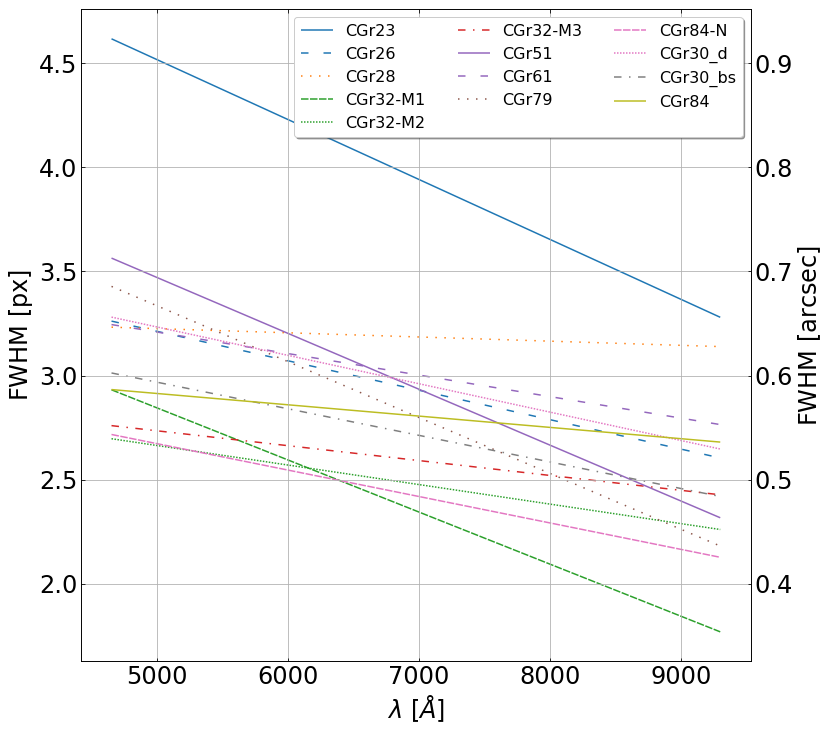

In [15]:
plt.rcParams["figure.figsize"] = (12, 12) # (w, h)
f = plt.figure()
plt.subplots_adjust(wspace=0.45, hspace=0.05)

from collections import OrderedDict

linestyles = OrderedDict(
    [('solid',               (0, ())),
     ('loosely dashed',      (0, (5, 10))),
     ('dotted',              (0, (1, 5))),
     ('densely dashed',      (0, (5, 1))),
     ('densely dotted',      (0, (1, 1))),
     ('dashed',              (0, (5, 5, 1, 5))),
     ('solid2',               (0, ())),
     ('loosely dashed2',      (0, (5, 10))),
     ('dotted2',              (0, (1, 5))),
     ('densely dashed2',      (0, (5, 1))),
     ('densely dotted2',      (0, (1, 1))),
     ('dashed2',              (0, (5, 5, 1, 5))),
     ('solid3',               (0, ()))])

cm   = plt.cm.get_cmap("tab10", len(listGroups))
cl   = [cm(i) for i in range(len(listGroups))]

lbls = ["CGr" + str(i) for i in listGroups.keys()]
lnst = []
for num, i in enumerate(linestyles.values()):
    if num<len(listGroups):
        lnst.append(i)

ax, tmp = asManyPlots(111, xx, yy,
                      xlabel=r"$\lambda\,\,[\AA]$",
                      ylabel=r'$\rm{FWHM\,\,[px]}$',
                      label=lbls,
                      linestyle=lnst,
                      marker='None',
                      color=cl,
                      showLegend=True,
                      legendTextSize=16,
                      locLegend='upper right',
                      legendNcols=3,
                      noCheck=True)

ax2  = ax.twinx()
ax2.tick_params(axis='y', direction='in', labelsize=24)
tcks = np.arange(0, 5, 0.5)
    
ax2.set_yticks(np.asarray(tcks)*0.2)
ax2.set_ylim([i*0.2 for i in list(ax.get_ylim())])
ax2.set_yticklabels([np.round(i, 2) for i in np.asarray(tcks)*0.2])

#ax2.set_yticklabels([np.round(i, 1) for i in np.asarray(tcks)*0.2], size=24)

ax2.set_ylabel(r'$\rm{FWHM}\,\,[arcsec]$', size=24)

plt.savefig('Plots/FWHM_variation_with_lambda.pdf', bbox_inches='tight')